# LV and RV Segmentation In 3D Cine MR Images Using U-Net
###### U-Net Paper: <a href="https://arxiv.org/abs/1505.04597">U-Net: Convolutional Networks for Biomedical Image Segmentation</a>
###### Dateset: <a href="https://acdc.creatis.insa-lyon.fr/">Automated Cardiac Diagnosis Challenge (ACDC)


## U-Net Architecture

<img src="materials/u-net-architecture.png"/>

<h4>U-Net Architecture has 3 parts:</h4>
<ol>
    <li>The Contracting/Downsampling Path</li>
    <li>Bottleneck</li>
    <li>The Expanding/Upsampling Path</li>
</ol>

<h4>Downsampling Path: </h4> 
<ol>
    <li>It consists of two 3x3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2x2 max pooling operation with stride 2 for downsampling.</li> 
    <li>At each downsampling step we double the number of feature channels.</li>
</ol>

<h4>Upsampling Path: </h4> 
<ol>
     <li> Every  step  in  the  expansive  path  consists  of  an  upsampling  of  the feature map followed by a 2x2 convolution (“up-convolution”), a concatenation with the correspondingly feature  map  from  the  downsampling  path,  and  two  3x3  convolutions,  each  followed by a ReLU.</li>
</ol>

<h4> Skip Connection: </h4>
The skip connection from the downsampling path are concatenated with feature map during upsampling path. These skip connection provide local information to global information while upsampling.

<h4> Final Layer: </h4>
At the final layer a 1x1 convolution is used to map each feature vector to the desired number of classes.


## CODE
#### Imports


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import MyUtils
from importlib import reload
import UNet
import pickle
from keras.utils import plot_model

#### User Input Data


In [2]:
# path_database = "Y:\\02-Work space\\\Hamid Alavi\\Dataset\\MICCAI 2017-ACDC- cine-MR - 150 cases\\training"
path_database = "C:\\Users\\hmral\\PycharmProjects\\Datasets\\MICCAI 2017-ACDC- cine-MR - 150 cases\\training"
id_all_data = np.arange(100,dtype=np.uint16) + 1
batch_size = 1
crop_size = (256,256)
voxel_size = 1.25
image_masks_names = ('background', 'RVcavity', 'LVmyo', 'LVcavity')[:]
image_masks_index = [{'background':0, 'RVcavity':1, 'LVmyo':2, 'LVcavity':3}[i] for i in image_masks_names]
print('active labels:',image_masks_index)

active labels: [0, 1, 2, 3]


#### Data Generation


In [3]:
MyUtils = reload(MyUtils)
id_training_data, id_testing_data = MyUtils.split_train_test_id(id_all_data,testing_share=0.2)
training_data = MyUtils.DataGenerator(path_database, id_training_data, batch_size, voxel_size, crop_size, image_masks_index, shuffle=True)
testing_data = MyUtils.DataGenerator(path_database, id_testing_data, batch_size, voxel_size, crop_size, image_masks_index, shuffle=False)
sample_batch_image, sample_batch_mask = testing_data[0]
sample_batch_mask = training_data._layers_multi2single(sample_batch_mask)

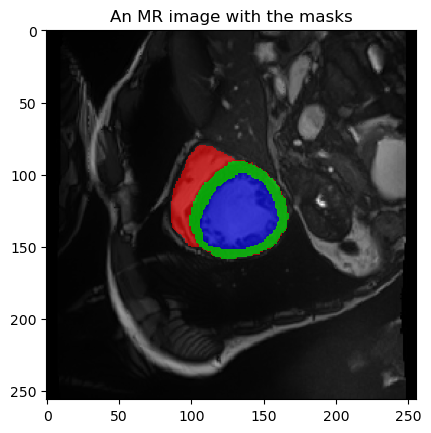

In [6]:
mycmap = ListedColormap([[0,0,0,0],[1,0,0,1],[0,1,0,1],[0,0,1,1]])
plt.imshow(sample_batch_image[5,:,:,0],cmap='gray')
plt.imshow(sample_batch_mask[5,:,:,0],cmap=mycmap,alpha=0.6)
plt.title('An MR image with the masks')
plt.show()

#### Create U-Net

In [16]:
UNet = reload(UNet)
MyUtils = reload(MyUtils)
UNetModel = UNet.create_UNet((None,None,1), (None,None,len(image_masks_index)))
UNetModel.compile(optimizer='adam', loss=MyUtils.dice_loss_multilabel, metrics=[MyUtils.dice_coef_multilabel])
UNetModel.summary(line_length=120)
plot_model(UNetModel)

Model: "model_2"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_3 (InputLayer)                  [(None, None, None, 1)]    0             []                                      
                                                                                                                        
 conv2d_42 (Conv2D)                    (None, None, None, 4)      40            ['input_3[0][0]']                       
                                                                                                                        
 batch_normalization_36 (BatchNormaliz  (None, None, None, 4)     16            ['conv2d_42[0][0]']                     
 ation)                                                                                                                 
               

In [17]:
UNetModel.fit_generator(training_data, validation_data=testing_data, epochs=100, workers=32)
# UNetModel.save_weights('UNetModel_weights.h5')

C:\Users\hmral\AppData\Local\Temp\ipykernel_9460\1064146242.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  UNetModel.fit_generator(training_data, validation_data=testing_data, epochs=100, workers=32)


Epoch 1/100


TypeError: in user code:

    File "C:\Users\hmral\anaconda3\envs\sarbazi\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\hmral\PycharmProjects\HearttSegmentationMRI\Python\new\MyUtils.py", line 119, in dice_loss_multilabel  *
        return 1 - dice_coef_multilabel(y_true, y_pred, numLabels)
    File "C:\Users\hmral\PycharmProjects\HearttSegmentationMRI\Python\new\MyUtils.py", line 115, in dice_coef_multilabel  *
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    File "C:\Users\hmral\PycharmProjects\HearttSegmentationMRI\Python\new\MyUtils.py", line 109, in dice_coef  *
        intersection = K.sum(y_true_f * y_pred_f)

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int8 of argument 'x'.


In [8]:
UNetModel.load_weights('UNetModel_weights.h5')

In [9]:
sample_test_image, sample_test_mask = testing_data[1]
predict_segment = UNetModel.predict(sample_test_image)
predict_segment = predict_segment.argmax(-1)
predict_segment = np.expand_dims(predict_segment, axis=-1)
sample_test_mask = sample_test_mask.argmax(-1)
sample_test_mask = np.expand_dims(sample_test_mask, axis=-1)

1/1 [==============================] - 6s 6s/step


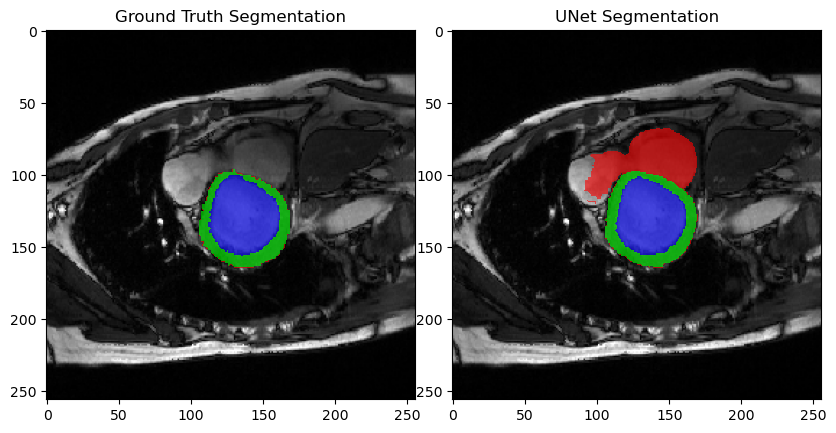

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,10))
i = 10
axs[0].imshow(sample_test_image[i,:,:,0], cmap='gray')
axs[0].imshow(sample_test_mask[i,:,:,0],cmap=mycmap,alpha=0.6)
axs[0].set_title("Ground Truth Segmentation")
axs[1].imshow(sample_test_image[i,:,:,0], cmap='gray')
axs[1].imshow(predict_segment[i,:,:,0],cmap=mycmap,alpha=0.6)
axs[1].set_title("UNet Segmentation")
plt.subplots_adjust(hspace=0.5, wspace=0.1)

## Test Unsegmented Images

from medpy.io import load as load_mhd_images
from cv2 import resize as resize_image
image_path = 'D:\\uni\\master\\medrik\\LVmodeler\\Data\\Databases\\Ultrasound\\CAMUS echocardiography 500 cases\\training\\patient0005\\patient0005_2CH_ES.mhd'
img, _ = load_mhd_images(image_path)
img = np.expand_dims(img.transpose((2, 0, 1)), axis=-1)
img_resized = np.zeros((img.shape[0],480,640,1))
for i in range(img.shape[0]):
    img_resized[i,:,:,0] = resize_image(img[i,:,:,0], (640,480))
predict_segment = UNetModel.predict(img_resized)